In [1]:
%load_ext autoreload
%autoreload 2

In [31]:
import torch
from UnarySim.sw.kernel.relu import UnaryReLU
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time


In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [33]:
device = "cuda:0"
# device = "cpu"

In [34]:
a = torch.nn.Parameter(torch.ge(torch.tensor([[1, 2], [3, 4]]), torch.tensor([[1, 1], [4, 4]])), requires_grad=False)

In [35]:
print(a)

Parameter containing:
tensor([[ True,  True],
        [False,  True]])


In [36]:
a.data = a.data.type(torch.float)

In [37]:
a

Parameter containing:
tensor([[1., 1.],
        [0., 1.]])

In [38]:
rng = "Sobol"
# rng = "Race"

in_dim = 1024

mode = "bipolar"

uReLU = UnaryReLU(buf_dep=4).to(device)

bitwidth = 8

iVec = ((torch.rand(in_dim)*(2**bitwidth)).round()/(2**bitwidth) - 0.5).to(device)
oVec = torch.nn.ReLU()(iVec)
print(iVec)
print(oVec)
        
iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode)().to(device)

iVecRNG = RNG(bitwidth, 1, rng)().to(device)
iVecBS = BSGen(iVecSource, iVecRNG).to(device)

iVecPE = ProgressiveError(iVec, mode=mode).to(device)
oVecPE = ProgressiveError(oVec, mode=mode).to(device)

with torch.no_grad():
    idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
    start_time = time.time()
    for i in range((2**bitwidth)):
        iBS = iVecBS(idx + i)
        iVecPE.Monitor(iBS)

        oVecU = uReLU(iBS)
        oVecPE.Monitor(oVecU)
        print(i)
        print(iBS)
        print(uReLU.acc.data)
        print(oVecU)

    print("--- %s seconds ---" % (time.time() - start_time))
    print("final input error: ", min(iVecPE()[1]), max(iVecPE()[1]))
    print("final output error:", min(oVecPE()[1]), max(oVecPE()[1]))
    print(oVec)
    print("final output pp:", oVecPE()[0].data)
    print("final output pe:", oVecPE()[1].data)
    
    result_pe = oVecPE()[1][0].cpu().numpy()
    print(torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))))
    print(result_pe)

tensor([-0.2188, -0.2734,  0.0469,  ...,  0.0977,  0.3750,  0.4102],
       device='cuda:0')
tensor([0.0000, 0.0000, 0.0469,  ..., 0.0977, 0.3750, 0.4102], device='cuda:0')
0
tensor([0, 0, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([7, 7, 9,  ..., 9, 9, 9], device='cuda:0')
tensor([0, 0, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
1
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
tensor([6, 6, 8,  ..., 8, 8, 8], device='cuda:0')
tensor([1, 1, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
2
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([7, 7, 9,  ..., 9, 9, 9], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
3
tensor([1, 0, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 8,  6, 10,  ..., 10, 10, 10], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
4
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)

tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
tensor([ 0,  0,  8,  ..., 10, 13, 13], device='cuda:0')
tensor([1, 1, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
42
tensor([0, 0, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 0,  0,  9,  ..., 11, 14, 14], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
43
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 1,  1, 10,  ..., 12, 15, 15], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
44
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
tensor([ 0,  0,  9,  ..., 11, 14, 14], device='cuda:0')
tensor([1, 1, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
45
tensor([0, 0, 0,  ..., 0, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 0,  0,  8,  ..., 10, 15, 15], device='cuda:0')
tensor([1, 1, 0,  ..., 0, 1, 1], device='cuda:0', dtype=torch.int8)
46
tensor([1, 1, 1,  ..., 1,

tensor([0, 0, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 0,  0, 12,  ..., 15, 15, 15], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
84
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
tensor([ 0,  0, 11,  ..., 14, 14, 14], device='cuda:0')
tensor([1, 1, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
85
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
tensor([ 0,  0, 10,  ..., 13, 13, 13], device='cuda:0')
tensor([1, 1, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
86
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 1,  1, 11,  ..., 14, 14, 14], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
87
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 2,  2, 12,  ..., 15, 15, 15], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
88
tensor([0, 0, 0,  ..., 0,

tensor([1, 1, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
125
tensor([0, 0, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 0,  0, 12,  ..., 15, 15, 15], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
126
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 1,  1, 13,  ..., 15, 15, 15], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
127
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 2,  2, 14,  ..., 15, 15, 15], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
128
tensor([0, 0, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 1,  1, 15,  ..., 15, 15, 15], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
129
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
tensor([ 0,  0, 14,  ..., 14, 14, 14], device='cuda:0')
tensor([1, 1, 0,  ..

tensor([ 1,  1, 14,  ..., 14, 15, 15], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
167
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 2,  2, 15,  ..., 15, 15, 15], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
168
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
tensor([ 1,  1, 14,  ..., 14, 14, 14], device='cuda:0')
tensor([1, 1, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
169
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
tensor([ 0,  0, 13,  ..., 13, 13, 13], device='cuda:0')
tensor([1, 1, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
170
tensor([0, 0, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 0,  0, 14,  ..., 14, 14, 14], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
171
tensor([1, 0, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 1,  0, 15, 

tensor([0, 0, 0,  ..., 0, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 1,  1, 14,  ..., 14, 15, 15], device='cuda:0')
tensor([1, 1, 0,  ..., 0, 1, 1], device='cuda:0', dtype=torch.int8)
209
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
tensor([ 0,  0, 13,  ..., 13, 14, 14], device='cuda:0')
tensor([1, 1, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
210
tensor([1, 0, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 1,  0, 14,  ..., 14, 15, 15], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
211
tensor([0, 0, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 0,  0, 15,  ..., 15, 15, 15], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
212
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
tensor([ 0,  0, 14,  ..., 14, 14, 14], device='cuda:0')
tensor([1, 1, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
213
tensor([0, 0, 0,  ..

tensor([1, 1, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
250
tensor([1, 0, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 1,  0, 14,  ..., 14, 15, 15], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
251
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 2,  1, 15,  ..., 15, 15, 15], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
252
tensor([0, 0, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
tensor([ 1,  0, 14,  ..., 14, 14, 14], device='cuda:0')
tensor([1, 1, 0,  ..., 0, 0, 0], device='cuda:0', dtype=torch.int8)
253
tensor([0, 0, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 0,  0, 15,  ..., 15, 15, 15], device='cuda:0')
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
254
tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int8)
tensor([ 1,  1, 15,  ..., 15, 15, 15], device='cuda:0')
tensor([1, 1, 1,  ..

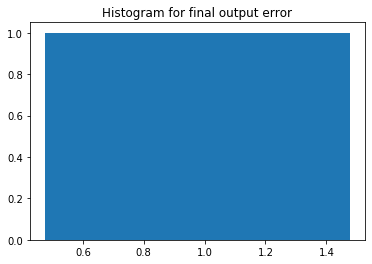

In [39]:
fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for final output error")
plt.show()

In [40]:
# passed test
# 1. unipolar,     scaled,     biased: passed
# 2. unipolar,     scaled, non-biased: passed
# 3. unipolar, non-scaled,     biased: passed
# 4. unipolar, non-scaled, non-biased: passed
# 5.  bipolar,     scaled,     biased: passed
# 6.  bipolar,     scaled, non-biased: passed
# 7.  bipolar, non-scaled,     biased: passed
# 8.  bipolar, non-scaled, non-biased: passed